In [1]:
import sys
import torch
from torch.nn import MSELoss
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable
from torch_geometric_temporal.signal import temporal_signal_split
sys.path.append('../../model/geometric_temporal/')
sys.path.append('../../dataset/')

In [2]:
from recurrent import LSTMGCNModel
from gdelt_dataset import GDELTDatasetLoader
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
seed = torch.random.manual_seed(52)

In [3]:
loader = GDELTDatasetLoader('../../data/dataset/gdelt_data_2.pkl', 1000)
dataset = loader.get_dataset()

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [8]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [9]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 7)

optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)

model.train()

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        max_x = torch.nan_to_num(snapshot.x).max()
        X = torch.div(snapshot.x, max_x + 1)
        X = torch.clamp(X, 10e-5, 10e3)
        X = torch.nan_to_num(X)
        max_w = torch.nan_to_num(snapshot.edge_attr).max()
        W = torch.div(snapshot.edge_attr, max_w + 1)
        W = torch.clamp(W, 10e-5, 100)
        W = torch.nan_to_num(W)
        
        y_hat = model(X, snapshot.edge_index, W)
        y_hat = torch.mm(y_hat, y_hat.T)
        y_true = snapshot.y
        cost = cost + torch.mean((y_hat-y_true)**2)
    cost = cost / (time+1)
    print(f'Cost: {cost}')
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Cost: 0.005610261578112841


  1%|▊                                                                                 | 1/100 [00:07<12:48,  7.76s/it]

Cost: 0.005606570281088352


  2%|█▋                                                                                | 2/100 [00:17<14:14,  8.72s/it]

Cost: 0.005603098776191473


  3%|██▍                                                                               | 3/100 [00:26<14:49,  9.17s/it]

Cost: 0.0055996752344071865


  4%|███▎                                                                              | 4/100 [00:37<15:18,  9.57s/it]

Cost: 0.00559628801420331


  5%|████                                                                              | 5/100 [00:46<14:57,  9.45s/it]

Cost: 0.005592935252934694


  6%|████▉                                                                             | 6/100 [00:56<14:57,  9.55s/it]

Cost: 0.005589599721133709


  7%|█████▋                                                                            | 7/100 [01:05<15:01,  9.69s/it]

Cost: 0.0055862851440906525


  8%|██████▌                                                                           | 8/100 [01:15<14:59,  9.78s/it]

Cost: 0.005582981277257204


  9%|███████▍                                                                          | 9/100 [01:25<14:38,  9.65s/it]

Cost: 0.0055796923115849495


 10%|████████                                                                         | 10/100 [01:35<14:36,  9.74s/it]

Cost: 0.005576414056122303


 11%|████████▉                                                                        | 11/100 [01:45<14:44,  9.94s/it]

Cost: 0.005573159549385309


 12%|█████████▋                                                                       | 12/100 [01:54<14:15,  9.73s/it]

Cost: 0.005569915287196636


 13%|██████████▌                                                                      | 13/100 [02:03<13:48,  9.52s/it]

Cost: 0.005566688720136881


 14%|███████████▎                                                                     | 14/100 [02:13<13:27,  9.39s/it]

Cost: 0.005563464015722275


 15%|████████████▏                                                                    | 15/100 [02:22<13:10,  9.30s/it]

Cost: 0.005560265854001045


 16%|████████████▉                                                                    | 16/100 [02:30<12:49,  9.16s/it]

Cost: 0.00555708073079586


 17%|█████████████▊                                                                   | 17/100 [02:39<12:35,  9.11s/it]

Cost: 0.005553907249122858


 18%|██████████████▌                                                                  | 18/100 [02:49<12:34,  9.20s/it]

Cost: 0.0055507514625787735


 19%|███████████████▍                                                                 | 19/100 [02:58<12:16,  9.09s/it]

Cost: 0.0055476101115345955


 20%|████████████████▏                                                                | 20/100 [03:07<12:11,  9.15s/it]

Cost: 0.005544474348425865


 21%|█████████████████                                                                | 21/100 [03:16<12:01,  9.13s/it]

Cost: 0.005541357211768627


 22%|█████████████████▊                                                               | 22/100 [03:25<11:50,  9.11s/it]

Cost: 0.005538249388337135


 23%|██████████████████▋                                                              | 23/100 [03:34<11:41,  9.11s/it]

Cost: 0.00553516112267971


 24%|███████████████████▍                                                             | 24/100 [03:43<11:31,  9.10s/it]

Cost: 0.005532079841941595


 25%|████████████████████▎                                                            | 25/100 [03:53<11:38,  9.32s/it]

Cost: 0.005529012531042099


 26%|█████████████████████                                                            | 26/100 [04:02<11:28,  9.30s/it]

Cost: 0.005525960121303797


 27%|█████████████████████▊                                                           | 27/100 [04:12<11:17,  9.27s/it]

Cost: 0.005522920284420252


 28%|██████████████████████▋                                                          | 28/100 [04:21<11:00,  9.17s/it]

Cost: 0.00551989022642374


 29%|███████████████████████▍                                                         | 29/100 [04:30<10:52,  9.19s/it]

Cost: 0.005516874138265848


 30%|████████████████████████▎                                                        | 30/100 [04:39<10:43,  9.19s/it]

Cost: 0.005513867828994989


 31%|█████████████████████████                                                        | 31/100 [04:48<10:31,  9.15s/it]

Cost: 0.005510876886546612


 32%|█████████████████████████▉                                                       | 32/100 [04:57<10:26,  9.21s/it]

Cost: 0.005507901310920715


 33%|██████████████████████████▋                                                      | 33/100 [05:06<10:13,  9.15s/it]

Cost: 0.005504933651536703


 34%|███████████████████████████▌                                                     | 34/100 [05:15<10:02,  9.12s/it]

Cost: 0.00550197483971715


 35%|████████████████████████████▎                                                    | 35/100 [05:25<09:53,  9.13s/it]

Cost: 0.0054990327917039394


 36%|█████████████████████████████▏                                                   | 36/100 [05:34<09:45,  9.15s/it]

Cost: 0.005496105179190636


 37%|█████████████████████████████▉                                                   | 37/100 [05:43<09:34,  9.13s/it]

Cost: 0.005493185482919216


 38%|██████████████████████████████▊                                                  | 38/100 [05:52<09:20,  9.05s/it]

Cost: 0.005490281619131565


 39%|███████████████████████████████▌                                                 | 39/100 [06:01<09:22,  9.22s/it]

Cost: 0.005487392656505108


 40%|████████████████████████████████▍                                                | 40/100 [06:11<09:13,  9.23s/it]

Cost: 0.005484512075781822


 41%|█████████████████████████████████▏                                               | 41/100 [06:20<09:07,  9.27s/it]

Cost: 0.0054816436022520065


 42%|██████████████████████████████████                                               | 42/100 [06:29<08:55,  9.23s/it]

Cost: 0.005478784907609224


 43%|██████████████████████████████████▊                                              | 43/100 [06:38<08:42,  9.17s/it]

Cost: 0.005475942511111498


 44%|███████████████████████████████████▋                                             | 44/100 [06:47<08:32,  9.15s/it]

Cost: 0.005473107565194368


 45%|████████████████████████████████████▍                                            | 45/100 [06:56<08:23,  9.15s/it]

Cost: 0.005470291245728731


 46%|█████████████████████████████████████▎                                           | 46/100 [07:06<08:29,  9.43s/it]

Cost: 0.005467485170811415


 47%|██████████████████████████████████████                                           | 47/100 [07:16<08:19,  9.42s/it]

Cost: 0.005464689806103706


 48%|██████████████████████████████████████▉                                          | 48/100 [07:25<08:04,  9.32s/it]

Cost: 0.0054619028232991695


 49%|███████████████████████████████████████▋                                         | 49/100 [07:34<07:48,  9.19s/it]

Cost: 0.005459134001284838


 50%|████████████████████████████████████████▌                                        | 50/100 [07:43<07:34,  9.09s/it]

Cost: 0.005456377286463976


 51%|█████████████████████████████████████████▎                                       | 51/100 [07:52<07:23,  9.06s/it]

Cost: 0.005453633610159159


 52%|██████████████████████████████████████████                                       | 52/100 [08:01<07:14,  9.05s/it]

Cost: 0.0054508959874510765


 53%|██████████████████████████████████████████▉                                      | 53/100 [08:10<07:06,  9.08s/it]

Cost: 0.005448178853839636


 54%|███████████████████████████████████████████▋                                     | 54/100 [08:19<07:01,  9.16s/it]

Cost: 0.005445466842502356


 55%|████████████████████████████████████████████▌                                    | 55/100 [08:28<06:49,  9.11s/it]

Cost: 0.005442769732326269


 56%|█████████████████████████████████████████████▎                                   | 56/100 [08:37<06:41,  9.12s/it]

Cost: 0.005440088454633951


 57%|██████████████████████████████████████████████▏                                  | 57/100 [08:46<06:32,  9.12s/it]

Cost: 0.005437413230538368


 58%|██████████████████████████████████████████████▉                                  | 58/100 [08:56<06:28,  9.25s/it]

Cost: 0.005434754304587841


 59%|███████████████████████████████████████████████▊                                 | 59/100 [09:05<06:17,  9.21s/it]

Cost: 0.005432105157524347


 60%|████████████████████████████████████████████████▌                                | 60/100 [09:14<06:08,  9.21s/it]

Cost: 0.005429464392364025


 61%|█████████████████████████████████████████████████▍                               | 61/100 [09:24<06:02,  9.31s/it]

Cost: 0.005426845978945494


 62%|██████████████████████████████████████████████████▏                              | 62/100 [09:33<05:51,  9.26s/it]

Cost: 0.005424233619123697


 63%|███████████████████████████████████████████████████                              | 63/100 [09:42<05:41,  9.22s/it]

Cost: 0.00542163010686636


 64%|███████████████████████████████████████████████████▊                             | 64/100 [09:51<05:29,  9.15s/it]

Cost: 0.005419048015028238


 65%|████████████████████████████████████████████████████▋                            | 65/100 [10:00<05:17,  9.08s/it]

Cost: 0.005416469182819128


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [10:09<05:07,  9.04s/it]

Cost: 0.005413909442722797


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [10:18<04:56,  8.97s/it]

Cost: 0.0054113538935780525


 68%|███████████████████████████████████████████████████████                          | 68/100 [10:27<04:51,  9.12s/it]

Cost: 0.005408810917288065


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [10:36<04:41,  9.07s/it]

Cost: 0.005406281445175409


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [10:45<04:31,  9.06s/it]

Cost: 0.005403767805546522


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [10:54<04:21,  9.02s/it]

Cost: 0.005401260685175657


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [11:03<04:12,  9.02s/it]

Cost: 0.005398765671998262


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [11:12<04:03,  9.02s/it]

Cost: 0.005396283231675625


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [11:21<03:55,  9.04s/it]

Cost: 0.005393815692514181


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [11:31<03:49,  9.16s/it]

Cost: 0.005391357466578484


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [11:40<03:38,  9.12s/it]

Cost: 0.005388911347836256


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [11:49<03:27,  9.02s/it]

Cost: 0.005386472214013338


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [11:57<03:17,  8.98s/it]

Cost: 0.005384050775319338


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [12:07<03:09,  9.04s/it]

Cost: 0.005381633527576923


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [12:16<03:00,  9.03s/it]

Cost: 0.005379239097237587


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [12:25<02:51,  9.03s/it]

Cost: 0.005376848392188549


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [12:34<02:44,  9.12s/it]

Cost: 0.005374470725655556


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [12:43<02:36,  9.18s/it]

Cost: 0.005372104234993458


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [12:52<02:25,  9.12s/it]

Cost: 0.005369748920202255


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [13:01<02:15,  9.05s/it]

Cost: 0.0053674085065722466


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [13:10<02:06,  9.01s/it]

Cost: 0.005365078337490559


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [13:19<01:57,  9.04s/it]

Cost: 0.005362751893699169


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [13:28<01:48,  9.06s/it]

Cost: 0.0053604417480528355


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [13:37<01:39,  9.03s/it]

Cost: 0.0053581492975354195


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [13:47<01:31,  9.19s/it]

Cost: 0.0053558568470180035


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [13:56<01:22,  9.22s/it]

Cost: 0.005353586748242378


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [14:05<01:13,  9.20s/it]

Cost: 0.0053513203747570515


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [14:14<01:03,  9.13s/it]

Cost: 0.005349061917513609


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [14:23<00:54,  9.11s/it]

Cost: 0.005346823483705521


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [14:32<00:45,  9.09s/it]

Cost: 0.005344588775187731


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [14:42<00:36,  9.17s/it]

Cost: 0.005342372227460146


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [14:51<00:27,  9.26s/it]

Cost: 0.00534015940502286


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [15:00<00:18,  9.18s/it]

Cost: 0.005337962415069342


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [15:09<00:09,  9.18s/it]

Cost: 0.005335773807018995


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:18<00:00,  9.19s/it]


In [11]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    max_x = torch.nan_to_num(snapshot.x).max()
    X = torch.div(snapshot.x, max_x + 1)
    X = torch.clamp(X, 10e-5, 10e3)
    X = torch.nan_to_num(X)
    max_w = torch.nan_to_num(snapshot.edge_attr).max()
    W = torch.div(snapshot.edge_attr, max_w + 1)
    W = torch.clamp(W, 10e-5, 100)
    W = torch.nan_to_num(W)
    
    y_hat = model(X, snapshot.edge_index, W)
    y_hat = torch.mm(y_hat, y_hat.T)
    y_true = snapshot.y
        
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.0045


In [20]:
y_true

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
y_hat

tensor([[0.0194, 0.0194, 0.0194,  ..., 0.0191, 0.0194, 0.0194],
        [0.0194, 0.0194, 0.0194,  ..., 0.0191, 0.0194, 0.0194],
        [0.0194, 0.0194, 0.0194,  ..., 0.0191, 0.0194, 0.0194],
        ...,
        [0.0191, 0.0191, 0.0191,  ..., 0.0188, 0.0191, 0.0191],
        [0.0194, 0.0194, 0.0194,  ..., 0.0191, 0.0194, 0.0194],
        [0.0194, 0.0194, 0.0194,  ..., 0.0191, 0.0194, 0.0194]],
       grad_fn=<MmBackward0>)

In [25]:
!pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
     ---------------------------------------- 7.2/7.2 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 930.9/930.9 KB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 54.8/54.8 KB 3.0 MB/s eta 0:00:00


You should consider upgrading via the 'c:\users\mimi_\documents\github\gdelt_tgnn\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

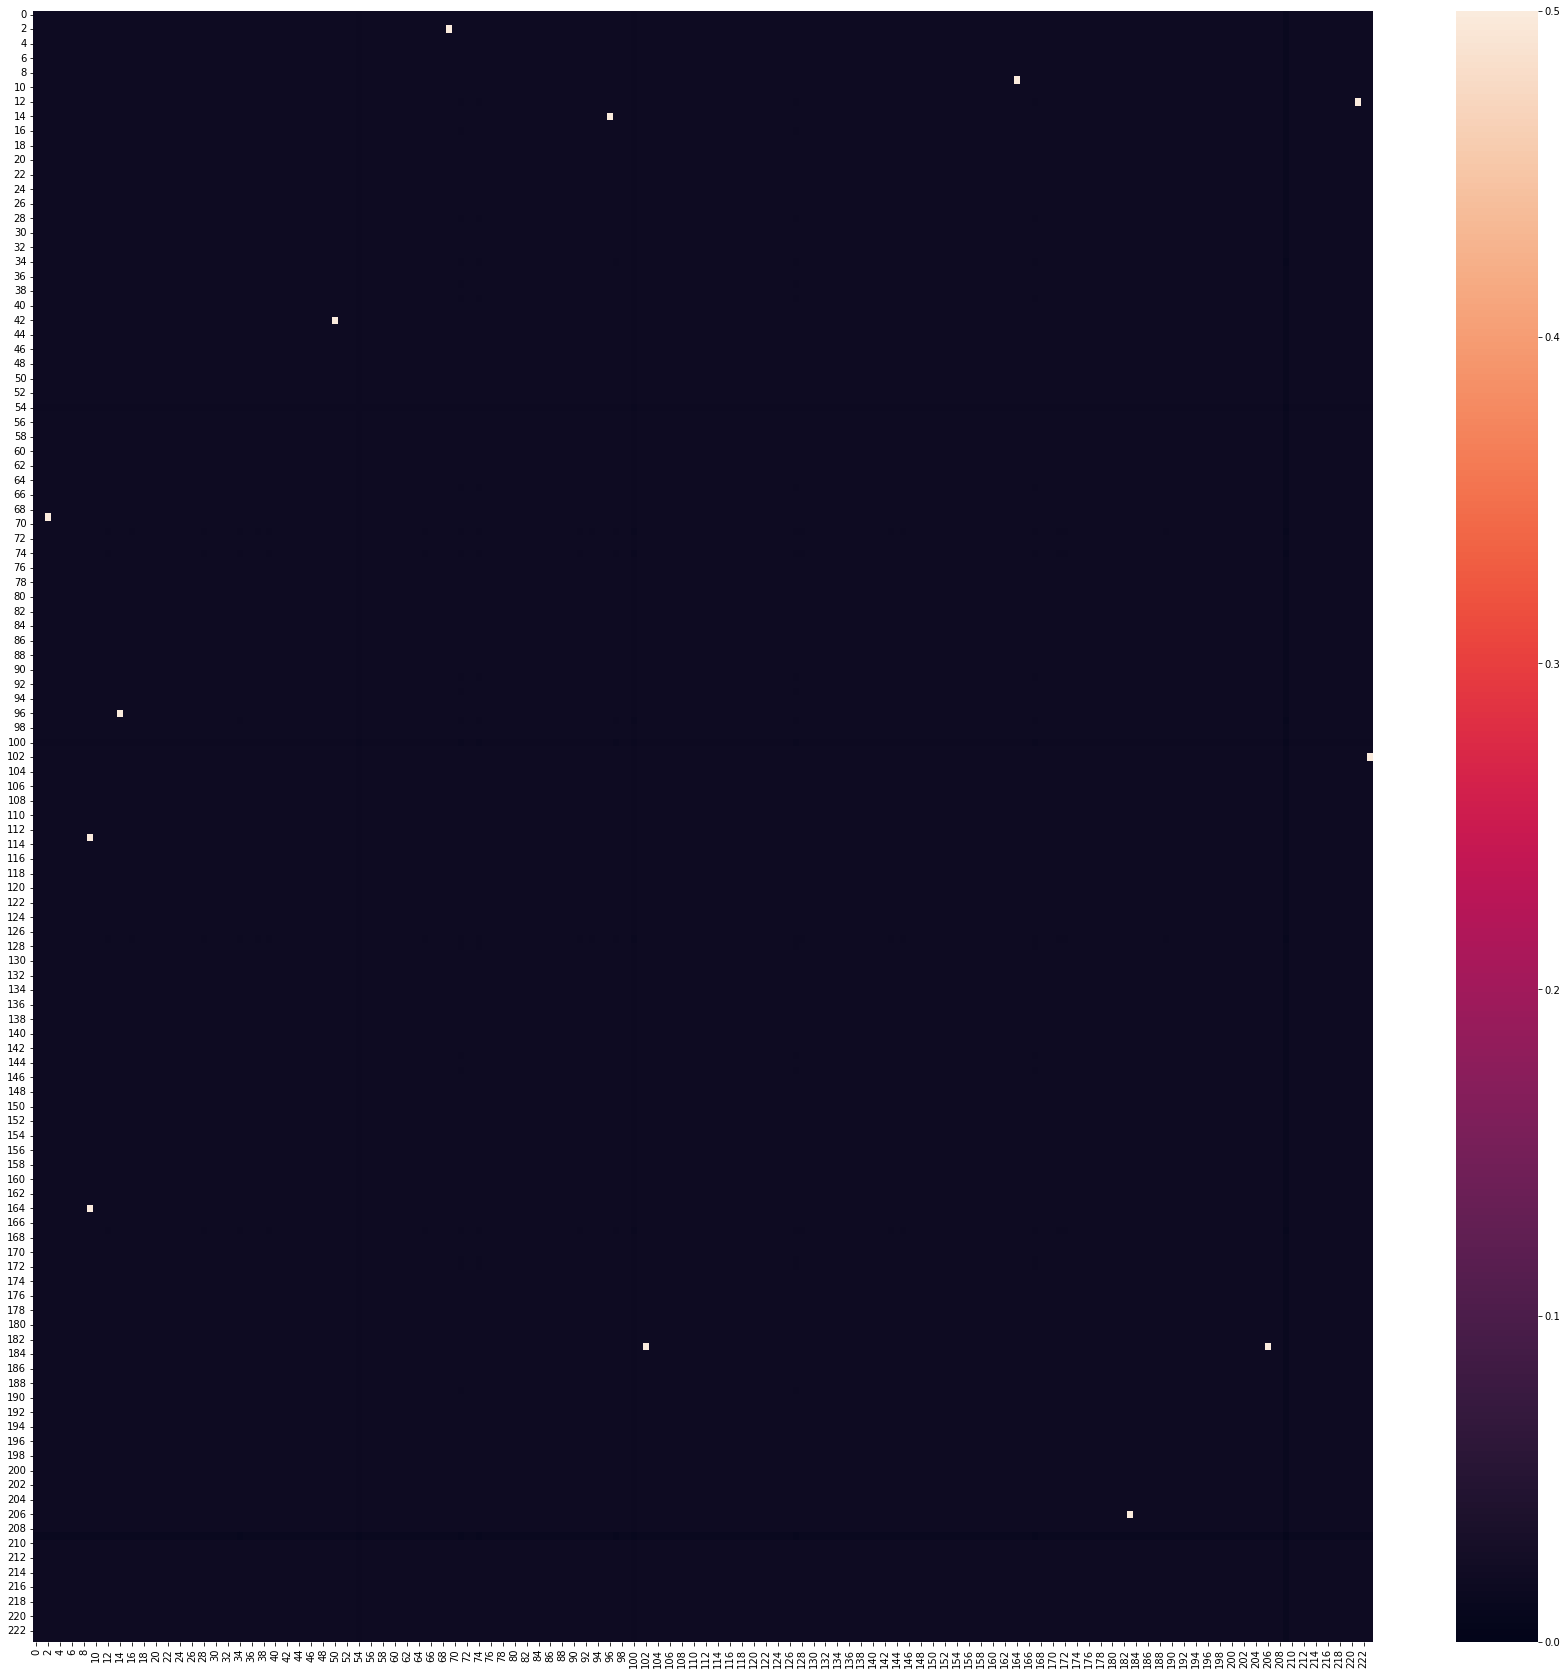

In [42]:
plt.figure(figsize=(30, 30))
sns.heatmap(abs(y_true-y_hat).detach().numpy(), vmin=0, vmax=0.5)
plt.show()

In [35]:
snapshot.edge_index

tensor([[  2,   9,  12,  14,  42,  69,  96, 102, 113, 164, 183, 183, 206],
        [ 69, 164, 221,  96,  50,   2,  14, 223,   9,   9, 102, 206, 183]])

In [40]:
torch.diag(snapshot.y[snapshot.edge_index[0]][:, snapshot.edge_index[1]])

tensor([ 2.1769, -2.0000, -2.0000,  1.2214, -2.0000, -1.8452,  2.8000,  4.0000,
         4.6667,  3.4000,  2.5092,  7.0000, -5.1429])

In [12]:
torch.save(model.state_dict(), '../../trained_models/GConvGRU.pt')